## 前処理

In [1]:
import pickle

import matplotlib.pyplot as plt

from emg_utils import *
from emg_cwt import *

### スカログラムの生成・保存

In [2]:
# *.matの読み込み
train_data,train_target=prepare_all()
test_data=prepare_testdata()

In [3]:
# trainデータ作成
subs = "0001 0002 0003 0004 0005".split()
gen=CwtGenerator(signal_channels=16, num_scale=112,fs=2000,fmin=10,fmax=500,wavelet="cmor1-2", use_sub=True)

data={}
for sub in subs:
    print(sub)
    images=gen.transform(train_data[sub])
    images=gen.resize(images, 112,112)
    data[sub]=images.astype(np.float32)

filename="train_f10-500cmor1-2.pkl"
with open(filename,"wb") as f:
    pickle.dump(data, f)

0001
0002
0003
0004
0005


In [4]:
# testデータ作成

data={}
for sub in subs:
    print(sub)
    images=gen.transform(test_data[sub])
    images=gen.resize(images, 112,112)
    data[sub]=images.astype(np.float32)

filename="test_f10-500cmor1-2.pkl"
with open(filename,"wb") as f:
    pickle.dump(data, f)

0001
0002
0003
0004
0005


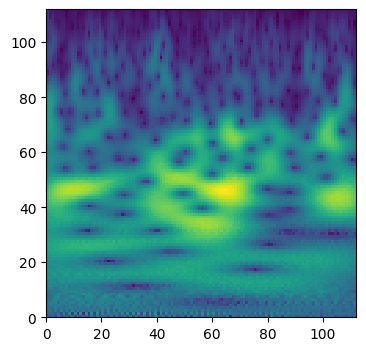

In [5]:
# スカログラムを1枚表示
plt.figure(figsize=(4,4))
plt.pcolormesh(data["0001"][0,0]**0.5)
plt.show()

## 学習

In [11]:
import os
import pickle

import numpy as np
from sklearn.model_selection import KFold

from emg_utils import *
from emg_cwt import *

### データ読み込み

In [12]:
with open('train_f10-500cmor1-2.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('test_f10-500cmor1-2.pkl', 'rb') as f:
    test_data = pickle.load(f)

_,train_target=prepare_all()
answer=load_data("reference.mat", "0005", 3)

In [13]:
# 左右チャンネルの相乗平均
for sub in train_data.keys():
    for data in [train_data,test_data]:
        signals = data[sub][:,:16]
        signals = signals**0.5
        average = np.sqrt(signals[:,0::2]*signals[:,1::2])
        data[sub]=np.concatenate([average,data[sub][:,16:]],axis=1)

### 各subで22回のクロスバリデーションを実行

In [14]:
def load_others_data(sub):
    others="0001 0002 0003 0004 0005".split()
    others.remove(sub)
    print(sub,others)
      
    X=np.concatenate([train_data[s] for s in others],axis=0)
    y=np.concatenate([train_target[s] for s in others],axis=0)

    if sub != "0005":
        X = np.concatenate([X,test_data["0005"]],axis=0)
        y = np.concatenate([y,rotate_data(answer,np.pi)],axis=0)
    return X,y

In [15]:
def train(sub,kernel_size,model,seed):
    X_others, y_others = load_others_data(sub)
    param=dict(
        num_epochs=100,
        switch_epochs=50,
        train_subject=sub,
        batch_size=64,
        lr=1e-3,
        weight_decay=1e-4,
        model_history_len=10,
        model_name=f"{model}.tv_in1k",
        seed=seed,
        train_mirror_data=False,
        time_padding=7,
        loss_ratio=[1,0],
        signal_channels=8,
    )        
    scale_param=dict(
        transform_type=None,
        normalize="max",
        image_layer_num=8,
    )

    cv=3
    kf = KFold(n_splits=cv, shuffle=True, random_state=seed)

    train_emg = train_data[sub]
    target = train_target[sub]

    scalers=[]
    weights=[]

    for isplit,(train_idx,val_idx) in enumerate(kf.split(train_emg)):
        X_train = train_emg[train_idx]
        y_train = target[train_idx]
        X_val = train_emg[val_idx]
        y_val = target[val_idx]
        
        scaler = SpectrogramScaler(**scale_param)    
        model = EMGModel(**param)
        model.model.renew_first_conv(kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        
        X=np.concatenate([X_train,X_others],axis=0)
        y=np.concatenate([y_train,y_others],axis=0)
        
        X=scaler.fit_transform(X)
        X_val=scaler.transform(X_val)
    
        train_loss,val_loss,_=model.fit(X,y,val_X=X_val,val_y=y_val, mirror_augmentation=None)

        scalers.append(scaler)
        weights.append(model.minimum_loss_weight)

    return scalers,weights

In [16]:
def save_model(models,trial,sub,save_path):
    os.makedirs(save_path,exist_ok=True)
    for i,model in enumerate(models):
        filename=f"{sub}_{trial}_{i}.pkl"
        filename=os.path.join(save_path,filename)

        with open(filename, 'wb') as f:
            pickle.dump(model, f)

In [17]:
kernel_list = [3,5,7,9,11,13,3,5,7,9,11,13,3,5,7,9,11,13,3,5,7,9,]
# seedは保存しておいたものを使用
seed_list = [72579,55794,20827,46577,46386,4559,47268,3117,55256,41568,98771,13048,91847,20892,15414,56104,44031,28615,23952,52559,3733,76412,78257,67594,40282,65805,71795,53292,67779,8089,41783,15043,25869,87947,18199,25683,79319,98994,49427,23624,97595,608,63155,38325,87704,90351,90392,42213,10276,37760,33176,77164,17954,66344,18550,37359,42612,90322,47082,65976,10582,41900,91020,53778,16348,77813,35403,17382,33831,38229,52349,47963,85446,65483,11220,73855,43679,7139,69162,87590,32501,43110,19987,71460,48571,15364,33958,2199,27715,67619,93791,57367,24234,50471,92644,80808,82389,3907,49638,94188,86748,20249,63337,66313,31246,69306,69801,30050,82628,91599,]
len(kernel_list),len(seed_list)

(22, 110)

In [ ]:
subs="0001 0002 0003 0004 0005".split()
trial=0
for kernel_size in kernel_list:
    for sub in subs:
        seed = seed_list[trial]
        scalers,weights=train(sub,kernel_size,"resnet18",seed)
        save_model(scalers,trial,sub,save_path="scalers")
        save_model(weights,trial,sub,save_path="weights")

        trial+=1
        

## 予測

In [1]:
import os
import json
import pickle

from emg_utils import *
from emg_cwt import *

### 学習済み重みで推論・保存

In [2]:
with open('test_f10-500cmor1-2.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [3]:
def save_prediction(json_list,trial,sub,save_path="predictions"):
    os.makedirs(save_path,exist_ok=True)
    for i,json_str in enumerate(json_list):
        filename=f"{sub}_{trial}_{i}.json"
        filename=os.path.join(save_path,filename)

        with open(filename, 'w') as f:
            f.write(json_str)

In [4]:
def predict(sub,scaler,weight,kernel_size):
    param=dict(
        num_epochs=100,
        switch_epochs=50,
        train_subject=sub,
        batch_size=64,
        lr=1e-3,
        weight_decay=1e-4,
        model_history_len=10,
        model_name="resnet18.tv_in1k",
        seed=0,
        train_mirror_data=False,
        time_padding=7,
        loss_ratio=[1,0],
        signal_channels=8,
    )

    model = EMGModel(**param)
    model.model.renew_first_conv(kernel_size=kernel_size, stride=1, padding=kernel_size//2)
    model.minimum_loss_weight = weight

    X_test=scaler.transform(test_data[sub])
    test_pred=model.predict(X_test,history="best",transform=True)

    pred_json = make_submit(subject=sub,data=test_pred)
    return pred_json


In [5]:
kernel_list = [3,5,7,9,11,13,3,5,7,9,11,13,3,5,7,9,11,13,3,5,7,9,]

In [ ]:
subs="0001 0002 0003 0004 0005".split()
trial=0
for kernel_size in kernel_list:
    for sub in subs:
        predictions=[]
        for i in range(3):
            prediction=predict(
                sub,
                scaler=pickle.load(open(f"scalers/{sub}_{trial}_{i}.pkl", 'rb')),
                weight=pickle.load(open(f"weights/{sub}_{trial}_{i}.pkl", 'rb')),
                kernel_size=kernel_size
            )
            predictions.append(prediction)

        save_prediction(predictions,trial,sub,save_path="predictions")
        trial+=1

### 異常検知により、低精度の推論結果を排除

In [6]:
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.neighbors import LocalOutlierFactor

from emg_utils import *

In [7]:
# *.matの読み込み
_,train_target=prepare_all()
answer=load_data("reference.mat", "0005", 3)

In [8]:
# 個別の推論結果の読み込み
def load_result(sub,load_path="predictions"):
    cv_result=[]
    files=glob.glob(os.path.join(load_path,f"{sub}*.json"))

    for file in files:
        with open(file) as f:
            loaded_dict = json.load(f)
        loaded_array = restore_submit(loaded_dict)
        cv_result.append(loaded_array)

    cv_result=np.array(cv_result)
    return cv_result

cv_results={}
for sub in train_target.keys():
    cv_results[sub]=load_result(sub)

In [9]:
def spline_data(motion:np.ndarray)->np.ndarray:
    '''
    motion: velocity (N,30,3)
    return: acc (N,30,3)
    '''
    spl_data=np.empty_like(motion)
    spl_data_d=np.empty_like(motion)
    for i,data in enumerate(motion):
        for d in range(3):
            t=np.arange(30,dtype=np.float32)
            v=data[:,d]
            spl=UnivariateSpline(t, v, s=1e-1, k=4)
            spl_d=spl.derivative(n=1)

            spl_data[i,:,d]=spl(t)
            spl_data_d[i,:,d]=spl_d(t)

    return spl_data_d,spl_data

def detection_data(vels):
    accs,spl=spline_data(vels)
    dydx=accs[:,:,2]/accs[:,:,0]
    dydx=np.arctan(dydx)

    x=spl[:,:,0].flatten()
    z=spl[:,:,2].flatten()
    dydx=dydx.flatten()
    ret = np.array([x,z,dydx]).T
    return ret

In [10]:
models={}
for sub in train_target.keys():
    vels=rotate_data(train_target[sub],np.pi)
    X_train=detection_data(vels)
    
    model = LocalOutlierFactor(novelty=True)
    model.fit(X_train)
    models[sub]=model

In [11]:
anomaly_scores={}
for sub,model in models.items():
    score=[]
    for p in range(len(cv_results[sub])):
        vels=cv_results[sub][p]
        X_test=detection_data(vels)
        score.append(model.decision_function(X_test).reshape((-1,30)))
    anomaly_scores[sub]=np.array(score)

In [15]:
threshold=0.16
outlier_mask = {}
for sub,score in anomaly_scores.items():
    ok_data=score.mean(axis=2)>threshold
    all_ng_count=np.sum(ok_data.sum(axis=0)==0)
    print(sub,all_ng_count,np.where(ok_data.sum(axis=0)==0))
    ok_data[:,ok_data.sum(axis=0)==0]=True
    outlier_mask[sub]=ok_data

0001 0 (array([], dtype=int64),)
0002 0 (array([], dtype=int64),)
0003 1 (array([116]),)
0004 0 (array([], dtype=int64),)
0005 0 (array([], dtype=int64),)


In [16]:
submit={}

for sub in train_target.keys():
    weight=np.where(outlier_mask[sub],1.0,0.0)        
    weight=weight[:,:,None,None]
    sum_data = (weight*cv_results[sub]).sum(axis=0)
    data_count = weight.sum(axis=0) # (trial,1)
    ave_data=sum_data/data_count
    submit[sub]=ave_data

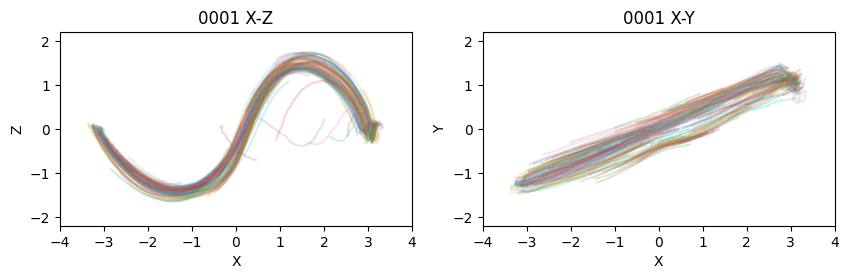

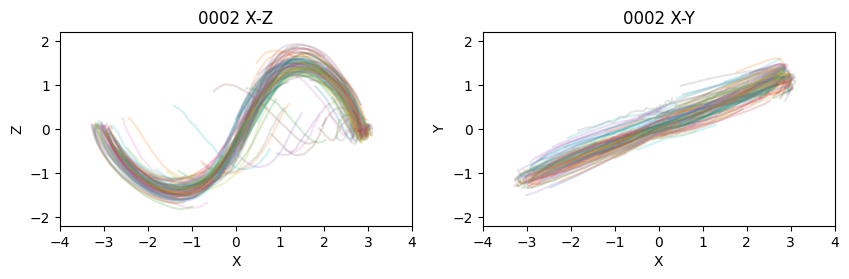

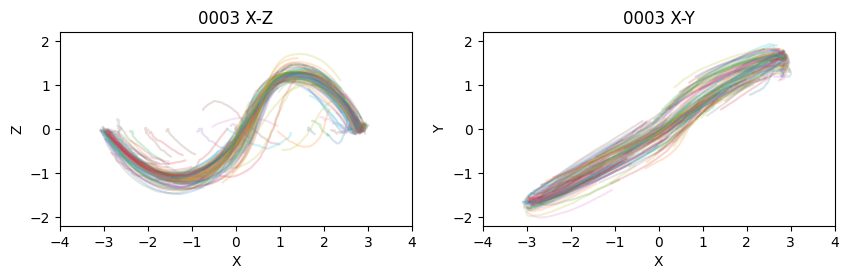

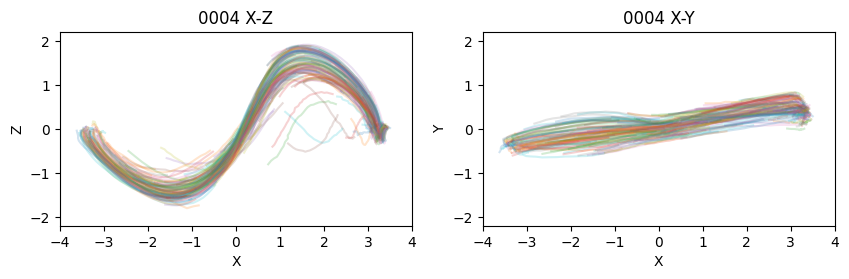

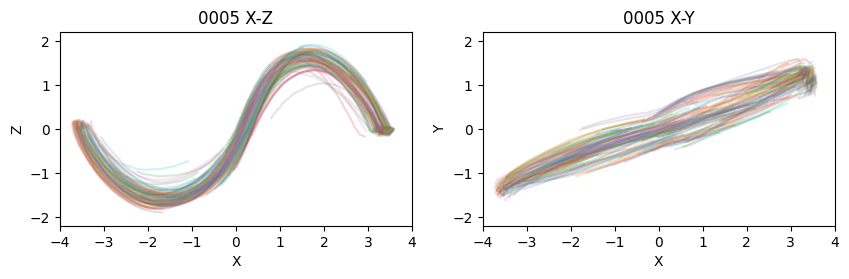

In [25]:
for sub in train_target.keys():
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    for line in rotate_data(submit[sub],np.pi):
        x=line[:,0]
        y=line[:,1]
        z=line[:,2]
        ax[0].plot(x,z, alpha=0.2)
        ax[1].plot(x,y, alpha=0.2)
    ax[0].set_title(f"{sub} X-Z")
    ax[0].set_xlim(-4,4)
    ax[0].set_ylim(-2.2,2.2)
    ax[0].set_aspect('equal')
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("Z")

    ax[1].set_title(f"{sub} X-Y")
    ax[1].set_xlim(-4,4)
    ax[1].set_ylim(-2.2,2.2)
    ax[1].set_aspect('equal')
    ax[1].set_xlabel("X")
    ax[1].set_ylabel("Y")
    plt.show()

### 予測結果の保存

In [29]:
save_submit(submit, "submit10280910.json")

submit10280910.json
